In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl

In [2]:
def conv3x3(in_channels, out_channels, stride=1, padding=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, 
                    padding=padding, bias=False)

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        # The first conv layer downsamples the input if stride > 1. This happens at the begining
        # of the 2nd, 3rd and 4th residual blocks. 
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # If the input has been downsampled by conv1 operation, correspondingly the input needs 
        # to be downsampled by the downsample operation before it can be added to the output of 
        # the residual block
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)            
        return out

In [4]:
# block : Type of block (BasicBlock or Bottleneck block)
def _make_layer(block, in_channels, out_channels, blocks, stride=1):
    downsample = None
    # if the conv layer performs a downsample of input, we need a downsample function to perform an equivalent
    # scaling of x.
    if in_channels != out_channels or stride > 1:
        downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        )
    layers = []
    # The first conv layer in the block that performs downsampling of the input
    layers.append(block(in_channels, out_channels, stride, downsample))     
    # the remaning layers in the block do no downsampling
    in_channels = out_channels    
    for _ in range(1, blocks):
        layers.append(block(in_channels, out_channels))
    return nn.Sequential(*layers)        

In [5]:
from typing import Optional
from pytorch_lightning.utilities.types import STEP_OUTPUT
import torch.nn.functional as F
import torchmetrics

# The input image size is 224 * 224 * 3
class ResNetLit(pl.LightningModule):
    def __init__(self, block, layers, num_classes, in_channels=3):
        super().__init__()
        self.block = block
        self.layers = layers
        self.num_classes = num_classes  
        self.train_loss = nn.CrossEntropyLoss()
        self.val_loss = nn.CrossEntropyLoss()
        self.train_accuracy = torchmetrics.Accuracy() 
        self.val_accuracy = torchmetrics.Accuracy()
        self.conv1_out_channels = 64     
        # in=224, out=112
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=self.conv1_out_channels, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(self.conv1_out_channels)
        self.relu = nn.ReLU(inplace=True)
        # in = 112, out = 56
        # out = ((in - padding) / stride) + 1
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # The first layer with 3 residual blocks stacked. No downsampling happens in the first layer
        # in = 56, out = 56, in_channels = out_channels = 64
        self.layer1 = _make_layer(block, in_channels=self.conv1_out_channels, 
                                    out_channels=self.conv1_out_channels, blocks=layers[0])
        # The second layer with 4 residual blocks. 
        # The first residual block dows downsampling directly by convolutional layers that have a stride of 2
        # in = 56, out = 28, in_channels = 64, out_channels = 128
        self.layer2 = _make_layer(block, in_channels=self.conv1_out_channels,
                                    out_channels=self.conv1_out_channels*2, blocks=layers[1], stride=2)                                    
        # The third layer with 6 residual blocks
        # in = 28, out = 14, in_channels = 128, out_channels = 256 
        self.layer3 = _make_layer(block, in_channels=self.conv1_out_channels*2,
                                    out_channels=self.conv1_out_channels*4, blocks=layers[2], stride=2)
        # The fourth layer with 3 residual blocks                                    
        # in = 14, out = 7, in_channels = 256, out_channels = 512 
        self.layer4 = _make_layer(block, in_channels=self.conv1_out_channels*4,
                                    out_channels=self.conv1_out_channels*8, blocks=layers[3], stride=2)
        # in = 7, out = 1                                       
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_features = self.conv1_out_channels*8, out_features=num_classes)

    def forward(self, x):        
        x = self.conv1(x)   # in: 224, out: 112
        x = self.bn1(x)     
        x = self.relu(x)    
        x = self.maxpool(x) # in: 112, out: 56

        x = self.layer1(x)  # in: 56, out: 56
        x = self.layer2(x)  # in: 56, out: 28
        x = self.layer3(x)  # in: 28, out: 14
        x = self.layer4(x)  # in: 14, out: 7

        x = self.avgpool(x) # in: 7, out: 1
        x = torch.flatten(x, 1)
        x = self.fc(x)  
        return x    

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self(X)
        #loss = F.cross_entropy(y_pred, y).detach().item()        
        loss = self.train_loss(y_pred, y)
        acc = self.train_accuracy(y_pred, y).detach().item()
        self.log("train_loss", loss, on_epoch=True, logger=True, prog_bar=True)
        self.log("train_accuracy", acc, on_epoch=True, logger=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self(X)
        loss = self.val_loss(y_pred, y).detach()        
        acc = self.val_accuracy(y_pred, y).detach()
        self.log("val_loss", loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("val_accuracy", acc, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)


In [6]:
import torchvision.transforms as transforms
from torchvision import datasets

data_path = "./mnist_data"
data_transform = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize([0.1307], [0.3081])])
train_mnist = datasets.MNIST(data_path, train=True, download=True, transform=data_transform)
val_mnist = datasets.MNIST(data_path, train=False, download=True, transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_mnist, batch_size=128, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_mnist, batch_size=128, num_workers=4)

<class 'torch.Tensor'>


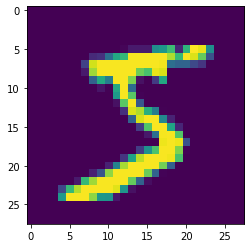

In [7]:
import matplotlib.pyplot as plt
img, label = train_mnist[0]
print(type(img))
plt.imshow(img.permute(1,2,0))

In [9]:
from pytorch_lightning.callbacks import ModelCheckpoint

mnist_model_lit = ResNetLit(ResidualBlock, layers=[3,4,6,3], num_classes=10, in_channels=1)
tb_logger = pl.loggers.TensorBoardLogger("logs", "mnist_model")
checkpoint_callback = ModelCheckpoint(dirpath="./model", monitor="val_loss", 
                                      filename="resnet34-{epoch:02d}-{val-loss:.2f}")
trainer = pl.Trainer(
    gpus=1,
    auto_select_gpus=True,
    progress_bar_refresh_rate=20,
    max_epochs=10,
    logger=tb_logger,
    callbacks=[checkpoint_callback]
)
trainer.fit(mnist_model_lit, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type              | Params
------------------------------------------------------
0  | train_loss     | CrossEntropyLoss  | 0     
1  | val_loss       | CrossEntropyLoss  | 0     
2  | train_accuracy | Accuracy          | 0     
3  | val_accuracy   | Accuracy          | 0     
4  | conv1          | Conv2d            | 3.2 K 
5  | bn1            | BatchNorm2d       | 128   
6  | relu           | ReLU              | 0     
7  | maxpool        | MaxPool2d         | 0     
8  | layer1         | Sequential        | 221 K 
9  | layer2         | Sequential        | 1.1 M 
10 | layer3         | Sequential        | 6.8 M 
11 | layer4         | Sequential        | 13.1 M
12 | avgpool        | AdaptiveAvgPool2d | 0     
13 | fc             | Linear            | 5.1 K 
------------------------------------------------------
21.

Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Inference on the validation set

In [36]:
model = ResNetLit.load_from_checkpoint(
    "./model/resnet34-epoch=09-val-loss=0.00.ckpt", 
    block=ResidualBlock,
    layers=[3,4,6,3],
    num_classes=10,
    in_channels=1)

model.eval()

incorrect = 0
total = 0
predicted_labels_incorrect = []
labels_incorrect = []
with torch.no_grad():
    counter=0
    for imgs, labels in val_loader:                
        predicted_labels = torch.argmax(model(imgs), dim=1)
        total += labels.shape[0]
        correct_pred = predicted_labels == labels
        incorrect_pred = ~correct_pred
        num_incorrect_pred = incorrect_pred.sum()
        incorrect += int(num_incorrect_pred)
        if num_incorrect_pred > 0:
            predicted_labels_incorrect.append(predicted_labels[incorrect_pred].numpy())
            labels_incorrect.append(labels[incorrect_pred].numpy())
print(f'Total no. of images in validation set: {total}')
print(f'Incorrectly classified images in validation set: {incorrect}')
inaccuracy = (incorrect / total) * 100        
print(f"Inaccuracy: {inaccuracy}%")

Total no. of images in validation set: 10000
Incorrectly classified images in validation set: 102
Inaccuracy: 1.02%


In [1]:
%load_ext tensorboard